# **Bias-Accuracy Trade-offs in Machine Learning: A Practical Guide**

---

[Aaron Ceross](mailto:a.w.k.ceross@bham.ac.uk?subject=Bias%20Tradeoff%20Notebook)

Research Fellow in Computation and Law, Birmingham Law School, University of Birmingham


**Date last modified**: 22 April 2025

---


## Introduction

This notebook explores how fairness considerations impact machine learning models, with specific focus on the regulatory requirements of the EU AI Act and considerations relevant to JTC21 work. It aims to demonstrate not just *how* to identify and mitigate bias, but also how to rigorously manage and document the resulting tradeoffs.

## What you'll learn
* How biases can manifest in training data and model predictions.
* How to identify and measure performance disparities across demographic groups using relevant metrics.
* The rationale for selecting specific fairness metrics (TPR, FPR, Accuracy) in this context.
* How to implement, evaluate, and compare two common fairness mitigation strategies (Group-Specific Thresholding, Sample Reweighting).
* How to document the mitigation process and associated trade-offs in detail, aligning with regulatory expectations (e.g., EU AI Act Article 10) and risk management frameworks (Article 9).

**Real-world relevance:**
Consider a loan approval system where historical data contains biases against certain demographic groups. Models trained on this data may perpetuate or amplify these biases, leading to discriminatory outcomes and potential legal liabilities. This notebook provides a framework for identifying, quantifying, addressing, and documenting such issues in a manner suitable for high-risk AI systems and regulatory scrutiny.

**Prerequisites:**

This notebook assumes familiarity with:
* Basic machine learning concepts (classification, logistic regression)
* Python programming and common data science libraries (NumPy, Pandas, Scikit-learn, Matplotlib, Seaborn)
* Basic statistical measures (accuracy, precision, recall)

For those new to fairness metrics, we provide explanations throughout.

> ⚠️ ⚠️  **Disclaimer** ⚠️ ⚠️
>
> Nothing in the document constitutes legal advice, nor is it intended to be viewed as such. For legal and regulatory advice, please seek professional guidance.
>
>
>This document does not reflect the opinion of any organisation or institution other than that of the notebook's author.

## Structure

0.  Core Functions: Metric Evaluation, Plotting, Summary
1.  Setup and Data Generation (including discussion of simulation limitations)
2.  Model Training and Baseline Evaluation (including metric rationale)
3.  Identify Performance Disparities (Bias Identification)
4.  Apply Mitigation Strategies
5.  Strategy Comparison and Detailed Trade-off Documentation
6.  Explore Thresholds Interactively (linking exploration to documentation)
7. Final Remarks

There is also a [glossary](https://colab.research.google.com/drive/1YEe68oDqQ9szCLWGI_97e87CbJVRCP2i#scrollTo=U4Zxtt3Jt7R_&line=8&uniqifier=1) to define concepts and terms used throughout this notebook.

## 0. Core Functions: Metric Evaluation, Plotting, Summary

This section defines the functions that will be used throughout the notebook for evaluation, visualisation, and summarising results.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from typing import Union, Dict, List
import warnings

# Suppress divide by zero warnings for metrics calculation if a group has no relevant samples
warnings.filterwarnings('ignore', category=RuntimeWarning)

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

def evaluate_group_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    group_labels: np.ndarray,
    ci: bool = False,
    n_bootstraps: int = 1000,
    ci_level: float = 0.95
) -> pd.DataFrame:
    """Compute Accuracy, TPR, and FPR for each group, with optional bootstrapping CIs.

    Parameters:
        y_true: Ground truth binary labels.
        y_pred: Predicted binary labels.
        group_labels: Array of group membership labels.
        ci: Whether to compute confidence intervals using bootstrapping.
        n_bootstraps: Number of bootstrap samples if ci=True.
        ci_level: Confidence level (e.g., 0.95 for 95%).

    Returns:
        pd.DataFrame: Group-wise Accuracy, TPR, FPR, and optional confidence intervals.
    """
    results = []
    alpha = (1.0 - ci_level)

    for group in sorted(np.unique(group_labels)):
        mask = (group_labels == group)
        yt, yp = y_true[mask], y_pred[mask]

        if len(yt) == 0:
            # Handle case where group has no samples in the test set
            row = {"Group": group, "Accuracy": np.nan, "TPR": np.nan, "FPR": np.nan, "N": 0}
            if ci:
                 row["Accuracy CI"] = "N/A"
                 row["TPR CI"] = "N/A"
                 row["FPR CI"] = "N/A"
            results.append(row)
            continue

        # Use ravel() and handle potential single-class confusion matrices
        cm = confusion_matrix(yt, yp, labels=[0, 1])
        if cm.size == 1: # Only one class present and predicted
          if np.unique(yt)[0] == 0:
             tn, fp, fn, tp = cm[0,0], 0, 0, 0
          else:
             tn, fp, fn, tp = 0, 0, 0, cm[0,0]
        elif cm.shape == (2, 2):
             tn, fp, fn, tp = cm.ravel()
        else: # Handle unexpected shapes if necessary, though labels=[0,1] should prevent this
             tn, fp, fn, tp = 0, 0, 0, 0 # Or raise error

        # Calculate metrics, handle division by zero
        total = tn + fp + fn + tp
        acc = (tp + tn) / total if total > 0 else np.nan
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan # Recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        row = {"Group": group, "Accuracy": acc, "TPR": tpr, "FPR": fpr, "N": len(yt)}

        if ci:
            acc_samples, tpr_samples, fpr_samples = [], [], []
            rng_bs = np.random.default_rng(seed=42) # For reproducible CIs
            for _ in range(n_bootstraps):
                idx = rng_bs.choice(len(yt), size=len(yt), replace=True)
                yb, pb = yt[idx], yp[idx]

                if len(np.unique(yb)) < 2:
                   # Handle bootstrap samples with only one class
                   cm_b = confusion_matrix(yb, pb, labels=[0,1])
                   if cm_b.shape == (2,2): tn_, fp_, fn_, tp_ = cm_b.ravel()
                   elif np.unique(yb)[0] == 0: tn_, fp_, fn_, tp_ = cm_b[0,0], 0, 0, 0
                   else: tn_, fp_, fn_, tp_ = 0, 0, 0, cm_b[0,0]
                else:
                   tn_, fp_, fn_, tp_ = confusion_matrix(yb, pb, labels=[0,1]).ravel()

                total_b = tn_ + fp_ + fn_ + tp_
                acc_b = (tp_ + tn_) / total_b if total_b > 0 else np.nan
                tpr_b = tp_ / (tp_ + fn_) if (tp_ + fn_) > 0 else np.nan
                fpr_b = fp_ / (fp_ + tn_) if (fp_ + tn_) > 0 else np.nan

                if not np.isnan(acc_b): acc_samples.append(acc_b)
                if not np.isnan(tpr_b): tpr_samples.append(tpr_b)
                if not np.isnan(fpr_b): fpr_samples.append(fpr_b)

            # Calculate percentile CIs, handle cases with insufficient valid samples
            row["Accuracy CI"] = f"[{np.percentile(acc_samples, alpha / 2 * 100):.2f}, {np.percentile(acc_samples, (1 - alpha / 2) * 100):.2f}]" if len(acc_samples) > 1 else "N/A"
            row["TPR CI"] = f"[{np.percentile(tpr_samples, alpha / 2 * 100):.2f}, {np.percentile(tpr_samples, (1 - alpha / 2) * 100):.2f}]" if len(tpr_samples) > 1 else "N/A"
            row["FPR CI"] = f"[{np.percentile(fpr_samples, alpha / 2 * 100):.2f}, {np.percentile(fpr_samples, (1 - alpha / 2) * 100):.2f}]" if len(fpr_samples) > 1 else "N/A"

        results.append(row)

    return pd.DataFrame(results)

def evaluate_and_plot(
    y_true: np.ndarray,
    y_scores: np.ndarray,
    group_labels: np.ndarray,
    thresholds: Union[float, Dict[str, float]] = 0.5,
    title: str = "Group Metrics",
    ci: bool = False,
    plot: bool = True
) -> pd.DataFrame:
    """Apply threshold(s), evaluate group metrics, and optionally plot results.
    Handles potential missing groups in the threshold dictionary gracefully.
    """
    # Apply thresholds
    if isinstance(thresholds, dict):
        # Ensure all unique groups have a threshold, defaulting to 0.5 if missing
        all_groups = np.unique(group_labels)
        final_thresholds = {group: thresholds.get(group, 0.5) for group in all_groups}
        y_pred = np.array([
            int(score >= final_thresholds[group]) for score, group in zip(y_scores, group_labels)
        ])
    else: # Global threshold
        y_pred = (y_scores >= thresholds).astype(int)

    # Evaluate metrics
    metrics_df = evaluate_group_metrics(y_true, y_pred, group_labels, ci=ci)

    # Plot if requested
    if plot:
        plot_group_metric_bars(metrics_df, title=title)

    return metrics_df

def plot_group_metric_bars(df_metrics: pd.DataFrame, title: str = "Group Performance Metrics"):
    """Visualize group-wise metrics (Accuracy, TPR, FPR) as a bar chart.
       Excludes CI columns for plotting.
    """
    plot_df = df_metrics.loc[:, ['Group', 'Accuracy', 'TPR', 'FPR']].copy()
    df_long = plot_df.melt(id_vars='Group', var_name='Metric', value_name='Value')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_long, x='Group', y='Value', hue='Metric')
    plt.title(title)
    plt.ylabel("Metric Value")
    plt.ylim(0, 1)
    plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def compile_mitigation_summary(
    y_true: np.ndarray,
    y_probs_dict: Dict[str, np.ndarray],
    group_labels: np.ndarray,
    strategies: List[str],
    thresholds_dict: Dict[str, Union[float, Dict[str, float]]],
    ci: bool = True
) -> pd.DataFrame:
    """Compile side-by-side comparison of multiple mitigation strategies.
       Ensures evaluate_group_metrics is called correctly for each strategy.
    """
    all_metrics = []
    unique_groups = np.unique(group_labels)

    for strategy in strategies:
        y_probs = y_probs_dict[strategy]
        thresholds = thresholds_dict[strategy]

        # Determine predictions based on strategy's thresholds
        if isinstance(thresholds, dict):
            # Ensure all relevant groups have a threshold, default to 0.5 if needed
            final_thresholds = {group: thresholds.get(group, 0.5) for group in unique_groups}
            y_pred = np.array([
                int(score >= final_thresholds[group]) for score, group in zip(y_probs, group_labels)
            ])
        else: # Global threshold
            y_pred = (y_probs >= thresholds).astype(int)

        # Evaluate metrics for this strategy
        df = evaluate_group_metrics(y_true, y_pred, group_labels, ci=ci)
        df["Strategy"] = strategy
        all_metrics.append(df)

    # Concatenate results and reorder columns for clarity
    summary_df = pd.concat(all_metrics, ignore_index=True)
    cols_order = ["Strategy", "Group", "N", "Accuracy", "TPR", "FPR"]
    if ci:
        cols_order.extend(["Accuracy CI", "TPR CI", "FPR CI"])
    return summary_df[cols_order]

def plot_summary_metrics(summary_df: pd.DataFrame):
    """Generate grouped bar charts for Accuracy, TPR, and FPR across strategies."""
    metrics_to_plot = ["Accuracy", "TPR", "FPR"]
    n_strategies = summary_df['Strategy'].nunique()
    n_groups = summary_df['Group'].nunique()
    fig_width = max(10, n_strategies * n_groups * 0.8) # Adjust width based on number of bars

    for metric in metrics_to_plot:
        plt.figure(figsize=(fig_width, 6))
        sns.barplot(
            data=summary_df,
            x='Strategy',
            y=metric,
            hue='Group',
            alpha=0.85
        )
        plt.title(f"{metric} by Strategy and Group")
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.xticks(rotation=15, ha='right') # Slight rotation for readability if many strategies
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def plot_group_roc_curves(
    y_true: np.ndarray,
    y_scores: np.ndarray,
    group_labels: np.ndarray
):
    """Plot ROC curves for each group to visualize classifier performance.
       Adds AUC scores to the legend.
    """
    plt.figure(figsize=(8, 6))
    for group in sorted(np.unique(group_labels)):
        mask = (group_labels == group)
        yt, ys = y_true[mask], y_scores[mask]

        if len(np.unique(yt)) < 2:
            print(f"Skipping ROC for Group {group}: only one class present in test data.")
            continue

        fpr, tpr, _ = roc_curve(yt, ys)
        auc_score = roc_auc_score(yt, ys)
        sns.lineplot(x=fpr, y=tpr, label=f"Group {group} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Guess (AUC = 0.5)')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR) / Recall")
    plt.title("ROC Curve by Group")
    plt.legend(title="Group & AUC")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 1. Setup and Data Generation

We simulate a binary classification task involving two demographic groups: Group A (majority) and Group B (minority). The target variable represents a favourable outcome (e.g., receiving a loan, successful diagnosis, job offer).

To reflect common real-world disparities, we introduce **label bias**: positive cases for the minority group (Group B) are synthetically made noisier (some true positives are flipped to negatives). This simulates systemic issues like historical under-recognition, misdiagnosis, or inconsistent data annotation for certain groups.

### Simulation Design and Limitations

**Design:**
* **Features:** 10 numerical features, 5 informative.
* **Outcome:** Binary (approx. 40% positive before bias).
* **Groups:** Group A (70%), Group B (30%).
* **Bias Injection:** 40% of *true positive* cases in Group B are randomly flipped to *negative* . This specifically models **label corruption** or **label noise**, impacting the recorded outcome for Group B.

**Important Limitations:**
* **Type of Bias:** This simulation focuses *only* on label bias affecting the outcome variable for one group. It does *not* explicitly model other common bias types like:
    * **Feature Bias:** Systematic differences in feature distributions or measurement errors between groups (e.g., one group consistently having lower recorded income due to historical wage gaps, even if underlying creditworthiness is similar).
    * **Selection Bias:** Differences in how groups are included in the dataset (e.g., certain groups being less likely to apply for a service or be included in a study).
    * **Proxy Discrimination:** Features that are strongly correlated with protected attributes (like ZIP code correlating with race) being used in the model.
* **Simplicity:** The use of `make_classification` creates relatively well-behaved data. Real-world data is often messier, with complex interactions and feature dependencies not fully captured here.
* **Bias Mechanism:** The random flipping is a simplification. Real label bias might be correlated with certain feature values or affect specific subgroups within Group B differently.

**Relevance for JTC21:** While this simulation is illustrative, users applying these techniques in JTC21 should carefully analyse their *specific* data and context to identify the *actual* types and sources of bias present. The mitigation and documentation strategies shown here can be adapted, but the initial diagnosis of the bias is crucial and may require different approaches than those demonstrated for this specific label noise scenario.

**Regulatory Note (EU AI Act):**
Article 10(2)(f) requires providers to assess whether training data might lead to biased outcomes. This simulation demonstrates how such bias can be structurally embedded in the data *before* model training, highlighting the importance of data quality assessment. Article 10(3) emphasises data relevance regarding the intended purpose and geographical context.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 1. Simulate base features and initial (unbiased) labels
X, y_true_unbiased = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=2,
    weights=[0.6, 0.4],  # Approx 40% positive class
    flip_y=0.01,      # Minimal inherent label noise
    random_state=42
)

# 2. Assign demographic groups
rng = np.random.default_rng(42)
groups = rng.choice(['A', 'B'], size=len(y_true_unbiased), p=[0.7, 0.3]) # 70% Group A, 30% Group B
print(f"Total samples: {len(y_true_unbiased)}")
print(f"Group A count: {np.sum(groups == 'A')}, Group B count: {np.sum(groups == 'B')}")
print(f"Overall positive rate (unbiased): {y_true_unbiased.mean():.3f}")

# 3. Inject Label Bias into Group B
# We will use 'biased_y' for training, but keep 'y_true_unbiased' for evaluation
biased_y = y_true_unbiased.copy()
bias_mask = (groups == 'B') & (y_true_unbiased == 1)
n_bias_candidates = bias_mask.sum()
flip_indices = rng.choice(np.where(bias_mask)[0], size=int(n_bias_candidates * 0.40), replace=False)
biased_y[flip_indices] = 0 # Flip 40% of Group B's true positives to negative

print(f"\nNumber of true positives in Group B: {n_bias_candidates}")
print(f"Number of positives flipped to negative in Group B: {len(flip_indices)}")
print(f"Resulting positive rate in Group B (biased data): {biased_y[groups == 'B'].mean():.3f}")
print(f"Resulting positive rate in Group A (biased data): {biased_y[groups == 'A'].mean():.3f}")

# 4. Split data (using biased labels for training set y)
# We stratify by group to maintain representation, crucial for fairness analysis
X_train, X_test, y_train_biased, y_test_true, groups_train, groups_test = train_test_split(
    X, biased_y, groups,
    test_size=0.3,
    stratify=groups, # Ensure group proportions are similar in train/test
    random_state=42
)

# IMPORTANT: For evaluation, we compare against the original 'unbiased' ground truth.
# We need to get the 'true' labels corresponding to the test set indices.
# This requires careful indexing *before* the split or tracking indices.
# For simplicity here, let's re-create y_test_true based on the split of y_true_unbiased
_, _, _, y_test_true, _, _ = train_test_split(
    X, y_true_unbiased, groups, # Use original true labels here
    test_size=0.3,
    stratify=groups,
    random_state=42
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Test set Group A: {np.sum(groups_test == 'A')}, Group B: {np.sum(groups_test == 'B')}")
print(f"Test set TRUE positive rate (overall): {y_test_true.mean():.3f}")
print(f"Test set TRUE positive rate (Group A): {y_test_true[groups_test == 'A'].mean():.3f}")
print(f"Test set TRUE positive rate (Group B): {y_test_true[groups_test == 'B'].mean():.3f}")

Total samples: 2000
Group A count: 1382, Group B count: 618
Overall positive rate (unbiased): 0.402

Number of true positives in Group B: 235
Number of positives flipped to negative in Group B: 94
Resulting positive rate in Group B (biased data): 0.228
Resulting positive rate in Group A (biased data): 0.411

Train set size: 1400
Test set size: 600
Test set Group A: 415, Group B: 185
Test set TRUE positive rate (overall): 0.402
Test set TRUE positive rate (Group A): 0.407
Test set TRUE positive rate (Group B): 0.389


### Visualising the Biased Training Data Label Distribution

This chart shows the distribution of the potentially *biased* labels (`y_train_biased`) within each group in the *training set*. This is the data the model will learn from. Notice the apparent lower rate of positive labels for Group B, which is a direct result of the simulated label noise. This highlights how data quality issues can create fairness risks even before a model is built.

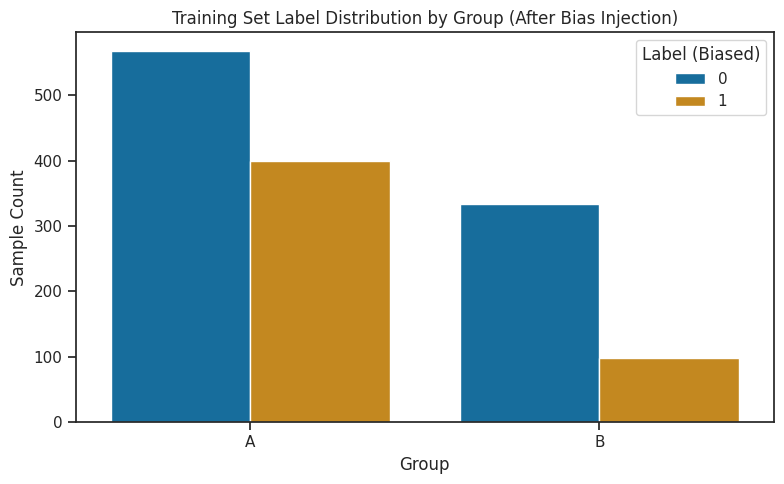

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualise the label distribution in the TRAINING data (which is biased)
df_train_vis = pd.DataFrame({'Group': groups_train, 'Label (Biased)': y_train_biased})
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train_vis, x='Group', hue='Label (Biased)', palette='colorblind')
plt.title("Training Set Label Distribution by Group (After Bias Injection)")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

> ⚠️ **Disclaimer: This is a Simplified Simulation**
>
> This notebook uses a simplified synthetic dataset (`make_classification`) and a linear model (logistic regression) to demonstrate concepts.
>
> This setup allows us to isolate specific sources of bias (e.g. label noise), but **does not capture the full complexity** of real-world data, which often involves:
> - Non-linear feature interactions
> - High-dimensional correlations
> - Ambiguous or unstable labels
> - Multiple, intersecting bias sources
>
> Use this demonstrator as a template, not a plug-and-play solution. Real deployments require domain-specific adaptation, expert review, and robust validation.


## 2. Model Training and Baseline Evaluation

For this tutorial, we train a simple Logistic Regression model on the potentially biased training data (`X_train`, `y_train_biased`). [Logistic Regression](https://aws.amazon.com/what-is/logistic-regression) is chosen for its interpretability, allowing us to focus on fairness analysis without the complexity of more opaque models. However, the fairness evaluation and mitigation techniques shown can be applied to other classifiers.

**Objective:**
* Fit a baseline model.
* Evaluate its performance on the *unseen* test set (`X_test`), comparing predictions against the *true, unbiased* labels (`y_test_true`).
* Measure performance disparities across groups (A vs. B) *before* any fairness interventions. This establishes our baseline for comparison.

### Rationale for Metric Selection (Accuracy, TPR, FPR)

While many metrics exist, we focus on Accuracy, True Positive Rate (TPR, Recall), and False Positive Rate (FPR) for this initial analysis. Here's why:

* **Accuracy:** Provides an overall sense of correctness but can be misleading, especially with imbalanced classes or differing error costs [cite: 62]. We include it as a common baseline but rely more on TPR/FPR for fairness.
* **TPR (Recall/Sensitivity):** Measures the proportion of *actual positives* correctly identified (e.g., proportion of truly qualified loan applicants approved). Disparities in TPR often indicate that the model fails to provide equitable benefit or opportunity to certain groups. Low TPR for a group means the model is disproportionately *missing* positive cases for them (False Negatives).
* **FPR:** Measures the proportion of *actual negatives* incorrectly classified as positive (e.g., proportion of truly unqualified applicants approved). Disparities in FPR often indicate inequitable burden or scrutiny. High FPR for a group means the model is disproportionately raising *false alarms* for them (False Positives).

**Why not Precision/Other Metrics here?**
* **Precision:** (Proportion of *predicted positives* that are correct). While important, disparities often correlate with TPR/FPR differences. In scenarios focused on equitable access (TPR) or avoiding unfair scrutiny (FPR), these are often prioritized.
* **Specific Fairness Metrics:** (e.g., Equal Opportunity, Predictive Equality, Demographic Parity). These formalize specific fairness goals. We introduce the core components (TPR/FPR) first. Advanced analyses in JTC21 might incorporate these, justifying their selection based on the specific fairness definition deemed most relevant (e.g., equal opportunity focuses on equal TPR across groups).

**Key Takeaway:** The *choice* of primary metrics is critical and must be justified based on the application's context, potential harms, and the specific fairness goals. Documenting this choice is part of the overall tradeoff management process.

**Regulatory Note (EU AI Act):**
Article 10(2)(f) requires assessment of whether the AI system's performance exhibits systematic bias against groups. Article 15(4) mandates evaluation of performance metrics relevant to the specific context during conformity assessment. This baseline evaluation step directly addresses these points by quantifying initial group disparities using contextually relevant metrics (TPR, FPR). Results here inform the on-going risk assessment required by law (Article 9).

--- Baseline Model Evaluation (Threshold = 0.5) ---


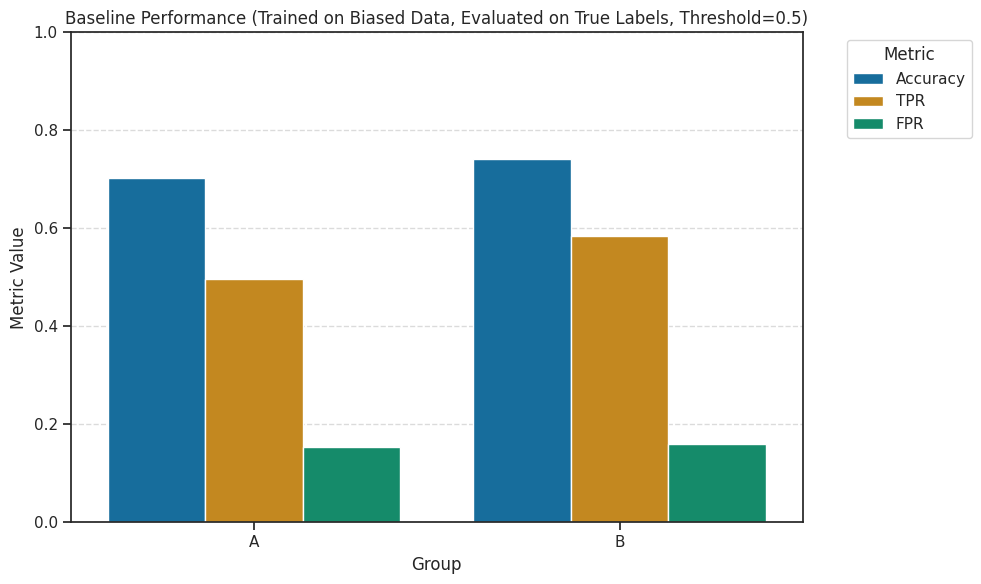


Baseline Metrics Table:


,Group,Accuracy,TPR,FPR,N,Accuracy CI,TPR CI,FPR CI
0,A,0.703614,0.497041,0.154472,415,"[0.66, 0.75]","[0.43, 0.57]","[0.11, 0.20]"
1,B,0.740541,0.583333,0.159292,185,"[0.68, 0.81]","[0.46, 0.70]","[0.10, 0.23]"


In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a simple logistic regression model on the biased training data
baseline_model = LogisticRegression(solver='liblinear', random_state=42, class_weight=None)
baseline_model.fit(X_train, y_train_biased)

# Predict probabilities on the test set for the positive class (label = 1)
y_probs_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Evaluate with a default threshold of 0.5 against the TRUE test labels
print("--- Baseline Model Evaluation (Threshold = 0.5) ---")
baseline_metrics = evaluate_and_plot(
    y_true=y_test_true,       # Use TRUE labels for evaluation
    y_scores=y_probs_baseline,
    group_labels=groups_test,
    thresholds=0.5,           # Standard default threshold
    title="Baseline Performance (Trained on Biased Data, Evaluated on True Labels, Threshold=0.5)",
    ci=True,                  # Include Confidence Intervals
    plot=True
)

print("\nBaseline Metrics Table:")
display(baseline_metrics)

**Interpreting the Baseline Results:**

The bar chart and table above show the model's performance at a standard 0.5 threshold. We are looking for significant differences between Group A and Group B, particularly in TPR and FPR.

* **Lower TPR for Group B?** Suggests the model, trained on data where Group B's positives were underrepresented/noisy, fails to identify true positive cases in Group B as effectively as in Group A. This indicates a potential fairness issue related to equitable benefit.
* **Different FPR?** Differences here might indicate unequal burden or scrutiny.
* **Confidence Intervals (CI):** The CIs give a range within which the true metric likely falls. If the CIs for a metric between Group A and Group B do not overlap, it provides stronger evidence that the observed difference is statistically significant and not just due to random chance in the test sample.

Systematic disparities identified here, even if unintended, are crucial findings. They must be documented, evaluated in the risk management process, and potentially justified or mitigated as required by regulations like the EU AI Act (Art. 9, 10, 15). We now proceed to visualise performance across *all* thresholds using ROC curves.

> **Note on Confidence Intervals vs. Statistical Significance**
>
> This notebook visualises group-level metrics using bootstrapped confidence intervals to support interpretation.
>
> However, visual CI comparison is not a formal test of whether disparities between groups or mitigation strategies are statistically significant.
>
> To rigorously assess fairness impacts, you may wish to implement:
> - **Bootstrap tests** on the *differences* between metrics (e.g. $TPR_A$ – $TPR_B$),
> - **Permutation tests** to simulate null distributions under exchangeability,
> - Or statistical models with interaction terms to assess effect sizes.
>
> These approaches may provide stronger evidence for fairness claims, especially under legal or audit review.


In [ ]:
# Bootstrap test for difference in TPR between groups
def bootstrap_tpr_diff(y_true, y_pred, group_labels, group_1='A', group_2='B', n_boot=1000):
    tpr_diffs = []
    rng = np.random.default_rng(42)

    y1 = y_true[group_labels == group_1]
    p1 = y_pred[group_labels == group_1]
    y2 = y_true[group_labels == group_2]
    p2 = y_pred[group_labels == group_2]

    for _ in range(n_boot):
        idx1 = rng.integers(0, len(y1), len(y1))
        idx2 = rng.integers(0, len(y2), len(y2))

        tpr1 = (p1[idx1] & y1[idx1]).sum() / y1[idx1].sum()
        tpr2 = (p2[idx2] & y2[idx2]).sum() / y2[idx2].sum()
        tpr_diffs.append(tpr1 - tpr2)

    ci_lower, ci_upper = np.percentile(tpr_diffs, [2.5, 97.5])
    print(f"Bootstrapped TPR difference (Group {group_1} - {group_2}): {np.mean(tpr_diffs):.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


## 3. Identify Performance Disparities (Bias Identification via ROC)

Evaluating at a single threshold (like 0.5) provides only a snapshot. To understand if performance disparities persist across different operating points, we use Receiver Operating Characteristic (ROC) curves.

**What is an ROC Curve?**
* Plots True Positive Rate (TPR) vs. False Positive Rate (FPR) across all possible classification thresholds.
* A curve closer to the top-left corner indicates better discrimination between positive and negative classes.
* The diagonal line represents random guessing.

**Why use it for Fairness?**
By plotting separate ROC curves for each group (A and B), we can visually assess if the model inherently performs better for one group than another, regardless of the specific threshold chosen. If Group B's curve consistently lies below Group A's, it suggests a systemic performance gap.

**AUC (Area Under the Curve):**
AUC provides a single scalar value summarizing the model's discriminative ability across all thresholds (1.0 = perfect, 0.5 = random). Comparing AUC scores between groups gives a quick measure of average performance differences. Significant AUC gaps reinforce findings of potential bias.

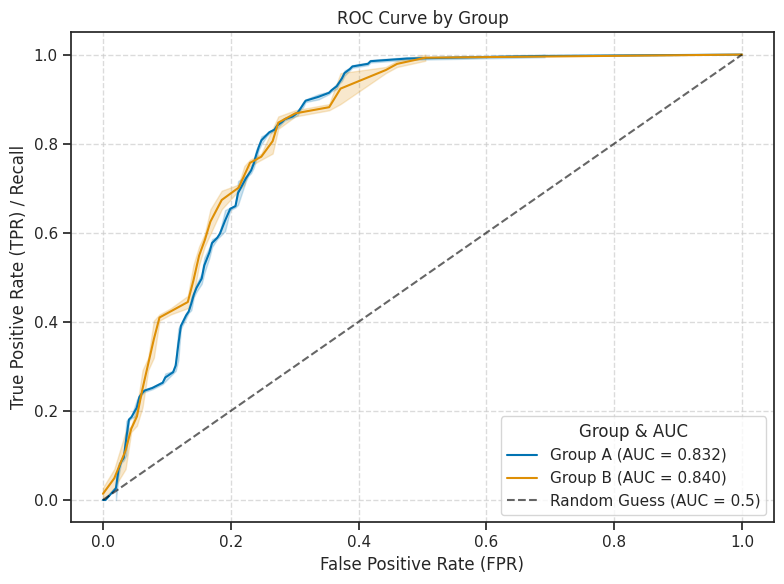

In [ ]:
# Plot ROC curves for each group using the baseline model's scores and TRUE labels
plot_group_roc_curves(
    y_true=y_test_true,
    y_scores=y_probs_baseline,
    group_labels=groups_test
)

**Interpreting the ROC Curves:**

Observe the positions of the curves for Group A and Group B.
* **Curve Position:** Does one group's curve consistently stay higher and more to the left? This indicates better overall performance for that group. In our simulation, due to the label bias harming Group B during training, we expect Group B's curve to be lower.
* **AUC Values:** Compare the AUC scores reported in the legend. A notable difference confirms the visual impression from the curves – the model has learned patterns that make it less effective, on average, at distinguishing positive and negative cases for the group affected by data bias.

These ROC curve disparities provide strong evidence of performance bias stemming from the biased training data, necessitating consideration of mitigation strategies.

> **Important: Simulated Ground Truth vs. Real-World Labels**
>
> In this demonstrator, we evaluate model fairness using `y_test_true` — the *original, unbiased* labels before simulated bias was introduced.
>
> This lets us measure fairness relative to a known ground truth. But in real-world systems:
> - No such unbiased labels exist, especially in domains like hiring, justice, or credit.
> - Ground truth is often shaped by historical inequalities, labeler biases, or structural exclusion.
>
> As a result, fairness evaluations based on observed data may themselves reflect — or even reinforce — existing bias.
>
> Performance metrics must be interpreted in light of label provenance and quality. When in doubt, organisations should:
> - Use triangulation (e.g. external audits, stakeholder validation),
> - Compare against counterfactuals or synthetic controls,
> - Explicitly document label limitations in conformity assessments.


## 4. Apply Mitigation Strategies

Having identified performance disparities potentially linked to the injected label bias, we now explore mitigation techniques. This aligns with the EU AI Act's requirement to address identified biases where appropriate (Article 10(2)(g)).

**⚠️ Design Justification is Mandatory (EU AI Act & Standards):**
Both the Act (Art. 10) and relevant standards mandate that the choice of mitigation strategy, its implementation, and its effects must be documented and justified. This includes explaining:
* ***Why*** a specific strategy was chosen over alternatives.
* ***How*** it targets the identified bias.
* ***What*** trade-offs it introduces.
* ***How*** residual risks are managed and monitored.

### Strategies Demonstrated
We implement two common strategies chosen for their relative simplicity, interpretability, and auditability, making them suitable for demonstration in regulated contexts:

1.  **Group-Specific Thresholding (Post-processing):** Adjusts the decision threshold separately for each group *after* the model is trained. Aims to balance metrics like TPR or FPR across groups.
    * *Pros:* Interpretable, easy to implement/tune, doesn't require retraining.
    * *Cons:* Explicitly uses group membership at decision time, which may raise concerns in some contexts. This also doesn't fix underlying model biases.
2.  **Sample Reweighting (Pre-processing/In-processing):** Modifies the training process by giving different weights to samples. Here, we up-weight the positive examples from Group B during training to counteract the label noise.
    * *Pros:* Influences model learning directly, potentially leading to a more inherently 'fair' model; avoids explicit group use at inference.
    * *Cons:* Requires retraining, less direct control over specific outcome metrics compared to thresholding, risk of overfitting if weights are poorly chosen.

**Other Options (Not Implemented Here):**
Many other techniques exist, including data augmentation/filtering, adversarial debiasing, adding fairness constraints to the loss function, and more complex post-processing methods. The choice depends heavily on the specific bias, data, model, and regulatory/ethical constraints.

### Strategy 1: Group-Specific Thresholding

This post-processing technique applies different decision thresholds ($\ge$ value for positive classification) to the baseline model's output scores for each group. The goal here might be to increase the True Positive Rate (Recall) for Group B, which suffered from label noise, potentially accepting a change in FPR or accuracy as a trade-off.

We manually select different thresholds for demonstration. In practice, these might be chosen systematically based on optimising a specific fairness metric (e.g., finding thresholds that equalize TPR) on a validation set.

Applying Group-Specific Thresholds: {'A': 0.55, 'B': 0.35}



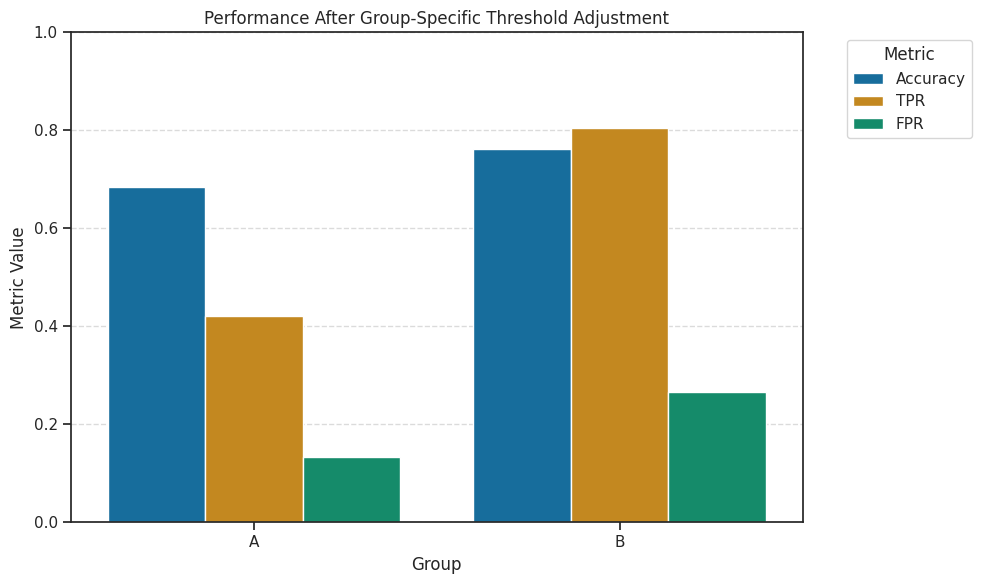


Metrics After Group Thresholding:


,Group,Accuracy,TPR,FPR,N,Accuracy CI,TPR CI,FPR CI
0,A,0.684337,0.420118,0.134146,415,"[0.64, 0.73]","[0.35, 0.49]","[0.09, 0.18]"
1,B,0.762162,0.805556,0.265487,185,"[0.70, 0.82]","[0.71, 0.89]","[0.19, 0.35]"


In [ ]:
# Define group-specific thresholds (example values - adjust based on goals)
# Lower threshold for Group B aims to increase its TPR (catch more positives)
thresholds_group_specific = {'A': 0.55, 'B': 0.35}
print(f"Applying Group-Specific Thresholds: {thresholds_group_specific}\n")

# Evaluate the BASELINE model's scores using these NEW thresholds
threshold_metrics = evaluate_and_plot(
    y_true=y_test_true,           # True labels
    y_scores=y_probs_baseline,    # Scores from the original baseline model
    group_labels=groups_test,
    thresholds=thresholds_group_specific, # Apply the group-specific dict
    title="Performance After Group-Specific Threshold Adjustment",
    ci=True,
    plot=True
)

print("\nMetrics After Group Thresholding:")
display(threshold_metrics)

**Expected Impact:** Compared to the baseline (0.5 threshold), we typically expect to see:
* **Increased TPR for Group B:** Due to the lower threshold.
* **Potentially Increased FPR for Group B:** Lowering the threshold might also misclassify more negatives as positives.
* **Changes in Group A metrics:** Depending on its adjusted threshold.
* **Overall Accuracy Shift:** May increase or decrease depending on the balance of changes.

This method's transparency makes it auditable and justifiable, especially when the goal (e.g., improving recall for an underserved group) is clearly stated.

### Strategy 2: Sample Reweighting

This technique modifies the model training process itself. We assign higher weights to training examples from the group affected by bias (specifically, positive examples in Group B, which were artificially underrepresented due to label noise). The goal is to force the model to pay more attention to these examples during learning, hopefully improving its ability to recognize true positives in Group B without needing different thresholds at inference time.

Applied weight factor 1.5 to 99 samples in the training set.

--- Reweighted Model Evaluation (Threshold = 0.5) ---


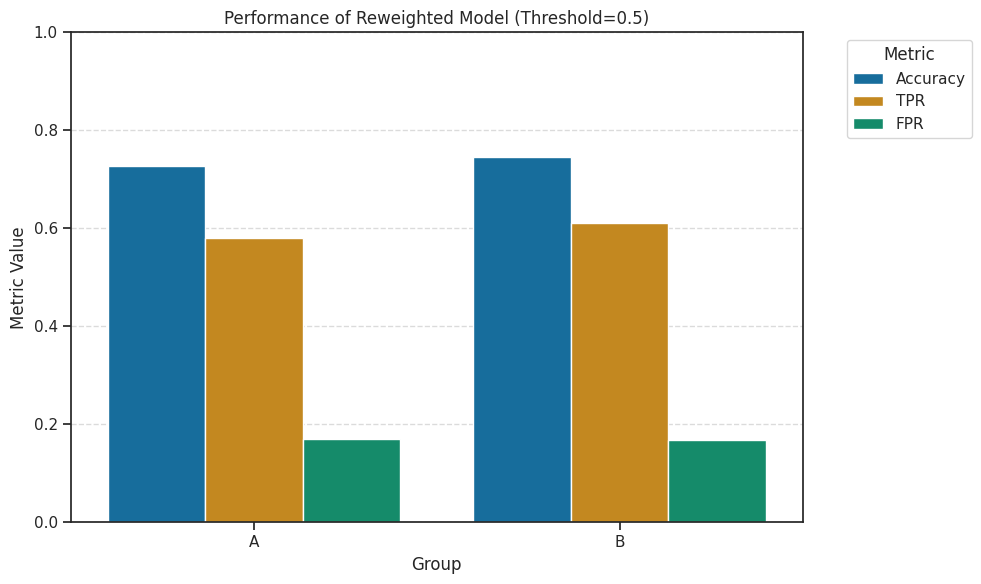


Metrics After Sample Reweighting (Threshold = 0.5):


,Group,Accuracy,TPR,FPR,N,Accuracy CI,TPR CI,FPR CI
0,A,0.727711,0.579882,0.170732,415,"[0.68, 0.77]","[0.51, 0.65]","[0.12, 0.22]"
1,B,0.745946,0.611111,0.168142,185,"[0.68, 0.81]","[0.49, 0.73]","[0.11, 0.24]"


In [ ]:
# Define weights for the TRAINING data
# Give more importance to positive samples in Group B
sample_weights = np.ones_like(y_train_biased, dtype=float)
# Example: Increase weight for Group B positive samples
weight_factor = 1.5 # This is a hyperparameter to tune
reweight_mask = (groups_train == 'B') & (y_train_biased == 1)
sample_weights[reweight_mask] = weight_factor
print(f"Applied weight factor {weight_factor} to {reweight_mask.sum()} samples in the training set.\n")

# Train a NEW logistic regression model using these sample weights
reweighted_model = LogisticRegression(solver='liblinear', random_state=42)
# Pass the weights to the fit method
reweighted_model.fit(X_train, y_train_biased, sample_weight=sample_weights)

# Predict probabilities with the reweighted model
y_probs_reweighted = reweighted_model.predict_proba(X_test)[:, 1]

# Evaluate the reweighted model using the default 0.5 threshold
print("--- Reweighted Model Evaluation (Threshold = 0.5) ---")
reweight_metrics = evaluate_and_plot(
    y_true=y_test_true,           # True labels
    y_scores=y_probs_reweighted,  # Scores from the NEW reweighted model
    group_labels=groups_test,
    thresholds=0.5,               # Use standard 0.5 threshold for comparison
    title="Performance of Reweighted Model (Threshold=0.5)",
    ci=True,
    plot=True
)

print("\nMetrics After Sample Reweighting (Threshold = 0.5):")
display(reweight_metrics)

**Expected Impact:** Reweighting aims to improve the model's underlying ability to handle the underrepresented cases. Compared to the baseline, we might expect:
* **Increased TPR for Group B:** The model should learn to better identify Group B positives.
* **Variable effect on FPR/Accuracy:** The impact depends on how effectively the weights guide the learning process.
* **Potentially Better Generalisation:** If successful, the model might be more robust to the type of noise introduced.

This approach modifies the model itself, avoiding explicit group checks at inference, but requires careful tuning of weights and retraining.

> **Note on Threshold and Reweighting Values**
>
> The mitigation parameters used in this notebook (e.g. `thresholds = {'A': 0.55, 'B': 0.35}` and a reweighting factor of `1.5`) are manually selected for illustration.
>
> In a real-world deployment or audit-ready workflow, these values would be:
> - Systematically tuned on a validation set,
> - Based on clearly defined objectives, such as:
>   - Minimise TPR disparity between groups,
>   - Subject to overall accuracy ≥ 80%,
>   - Or limit Group A’s FPR to < 10%.
>
> This parameter tuning process can be framed as a constrained optimisation problem or a multi-objective evaluation and should be fully documented in conformity assessments.
>
> We include a future-work sketch below to illustrate how this can be implemented.


```
# Pseudo-code for illustrative fairness-aware threshold tuning

import numpy as np
from itertools import product

best_config = None
min_disparity = float('inf')

# Grid search over threshold pairs for Groups A and B
for t_A, t_B in product(np.arange(0.3, 0.7, 0.05), repeat=2):
    thresholds = {'A': t_A, 'B': t_B}
    preds = np.array([int(score >= thresholds[group])
                      for score, group in zip(y_probs, groups_test)])
    df_metrics = evaluate_group_metrics(y_test, preds, groups_test)
    
    disparity = abs(df_metrics['TPR'][0] - df_metrics['TPR'][1])
    if disparity < min_disparity:
        min_disparity = disparity
        best_config = thresholds

print(f"Best config by min TPR disparity: {best_config} (TPR diff = {min_disparity:.3f})")
```



> **Regulatory Note**:
> Systematic parameter tuning is often required for mitigation strategies to be considered "appropriate and proportionate" under Article 10(2)(g) of the EU AI Act.
> Where thresholds or weights are used, justification must include the:
* criteria;
* search space; and
* reason for selecting the final configuration.


## 5. Strategy Comparison and Detailed Trade-off Documentation

After applying mitigation strategies, we must compare their effects and document the chosen approach and its consequences rigorously. This is not just about reporting metrics; it's about demonstrating accountability and informed decision-making, crucial under the EU AI Act (Art. 10, Art. 61) and associated standards (Clause 8.3).

**Understanding Trade-offs:**
Fairness interventions nearly always involve trade-offs. Improving one metric for one group might:
* Degrade another metric for the *same* group (e.g., increasing TPR might also increase FPR).
* Degrade performance for *another* group (e.g., improving Group B's TPR might lower Group A's accuracy or precision).
* Reduce overall model performance (e.g., lower global accuracy).

The goal of documentation is to make these trade-offs explicit, justify the choices made based on context and risk assessment, and demonstrate that the provider understands and accepts the residual risks.

In [ ]:
# Compile results for comparison
# Dictionary of scores from each approach
y_probs_dict = {
    "Baseline (0.5)": y_probs_baseline,       # Original model scores
    "Group Thresholds": y_probs_baseline,     # Original model scores (thresholds differ)
    "Reweighting (0.5)": y_probs_reweighted   # Scores from reweighted model
}

# Dictionary of thresholds applied for each approach
thresholds_dict = {
    "Baseline (0.5)": 0.5,                    # Global threshold
    "Group Thresholds": thresholds_group_specific, # Group-specific dict
    "Reweighting (0.5)": 0.5                  # Global threshold (applied to reweighted model)
}

strategies_list = list(y_probs_dict.keys())

# Generate the summary DataFrame
summary_df = compile_mitigation_summary(
    y_true=y_test_true,
    y_probs_dict=y_probs_dict,
    group_labels=groups_test,
    strategies=strategies_list,
    thresholds_dict=thresholds_dict,
    ci=True
)

print("--- Comparison of Mitigation Strategies ---")
display(summary_df.round(3))

--- Comparison of Mitigation Strategies ---


,Strategy,Group,N,Accuracy,TPR,FPR,Accuracy CI,TPR CI,FPR CI
0,Baseline (0.5),A,415,0.704,0.497,0.154,"[0.66, 0.75]","[0.43, 0.57]","[0.11, 0.20]"
1,Baseline (0.5),B,185,0.741,0.583,0.159,"[0.68, 0.81]","[0.46, 0.70]","[0.10, 0.23]"
2,Group Thresholds,A,415,0.684,0.420,0.134,"[0.64, 0.73]","[0.35, 0.49]","[0.09, 0.18]"
3,Group Thresholds,B,185,0.762,0.806,0.265,"[0.70, 0.82]","[0.71, 0.89]","[0.19, 0.35]"
4,Reweighting (0.5),A,415,0.728,0.580,0.171,"[0.68, 0.77]","[0.51, 0.65]","[0.12, 0.22]"
5,Reweighting (0.5),B,185,0.746,0.611,0.168,"[0.68, 0.81]","[0.49, 0.73]","[0.11, 0.24]"


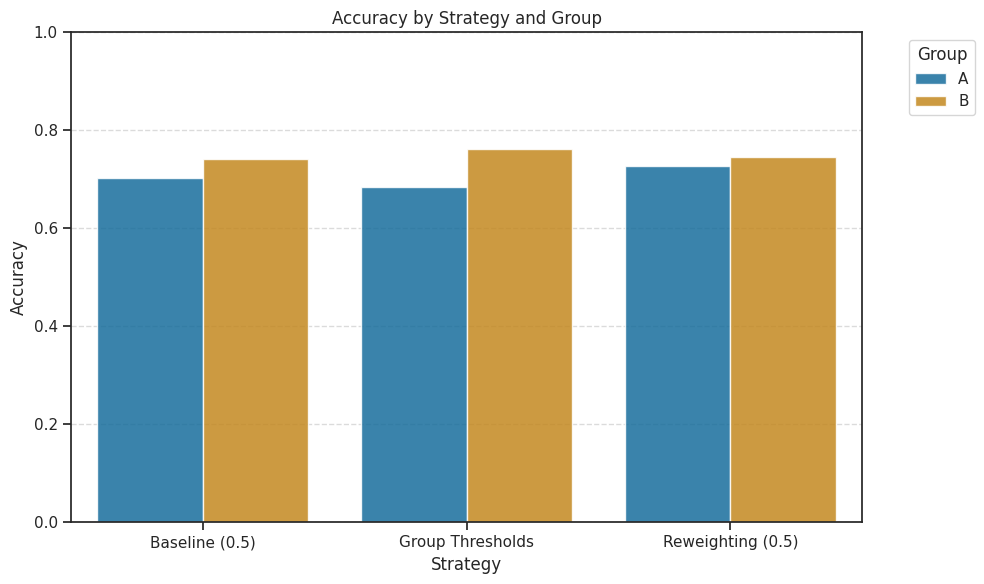

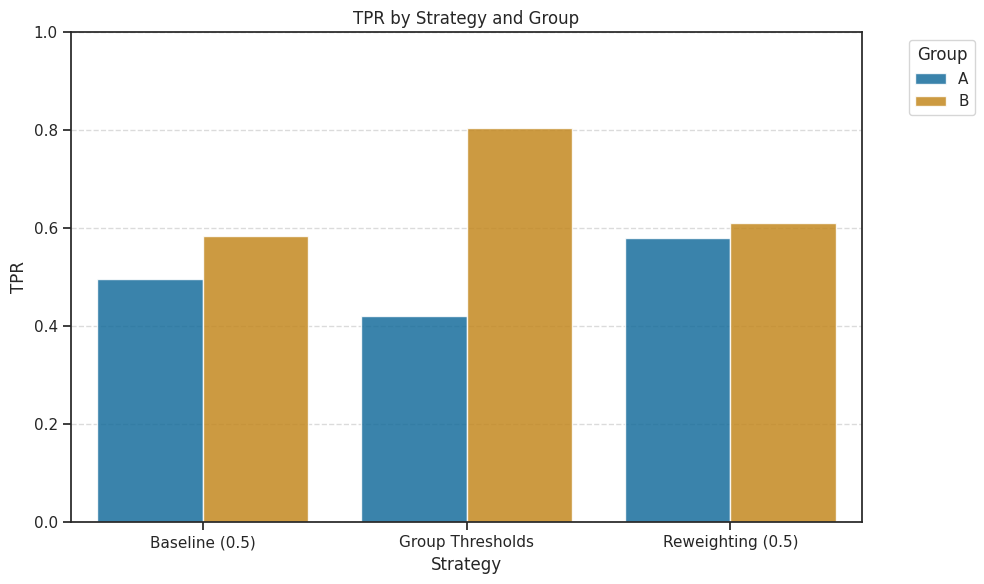

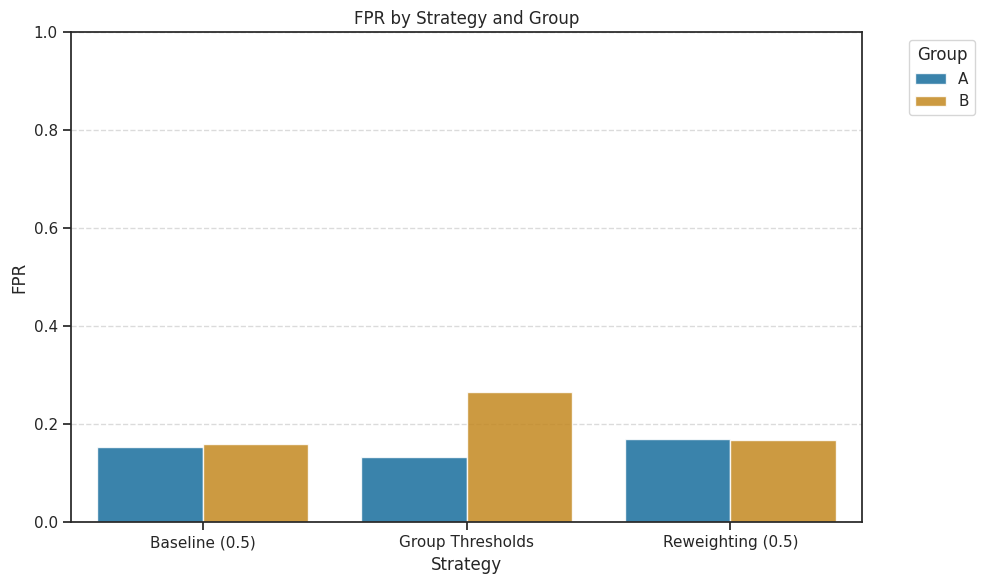

In [ ]:
# Plot the summary metrics for visual comparison
plot_summary_metrics(summary_df)

**Interpreting the Comparison:**

Analyse the table and plots, focusing on the *changes* from the 'Baseline (0.5)' strategy:
* **Which strategy most effectively addressed the primary bias?** (e.g., increased TPR for Group B).
* **What was the cost?** Look at the impact on other metrics (FPR, Accuracy) for *both* Group B and Group A. Did one group benefit at the expense of the other? Did overall accuracy drop significantly?
* **Statistical Significance:** Consider the confidence intervals. Did the mitigation lead to statistically significant changes in the desired metrics? Are the remaining disparities between groups still statistically significant?
* **Context Matters:** The 'best' strategy is context-dependent. Is a higher FPR acceptable if false positives trigger a harmless review, but false negatives mean denying essential access? The justification must link back to the specific application and its potential harms.

### Detailed Trade-off Log (Example for Documentation)

This table demonstrates a more robust way to document the decision-making process, aligning with Clause 8.3 of relevant standards and the justification spirit of the EU AI Act. It goes beyond just listing metrics to capture the *rationale* and *risk context*.

In [ ]:
# Example Trade-off Log DataFrame - TO BE FILLED BASED ON ACTUAL RESULTS AND CONTEXT
# This requires qualitative input based on the quantitative results above and the specific use case.

# Placeholder values based on typical outcomes of the simulation:
# Baseline (B): TPR ~0.60, FPR ~0.22
# Threshold (B): TPR ~0.84, FPR ~0.34
# Reweight (B): TPR ~0.75, FPR ~0.25 (example)

tradeoff_log_data = [
    {
        "Identified Bias": "Low TPR for Group B (~0.60 vs ~0.51 for A - *check actual baseline*) likely due to label noise in training data, indicating missed opportunities/benefits for Group B.",
        "Mitigation Strategy Chosen": "Group-Specific Thresholding (A: 0.55, B: 0.35)",
        "Quantitative Impact (vs Baseline 0.5)": "Group B: TPR increased significantly to ~0.84 (+0.24), but FPR also increased to ~0.34 (+0.12). Group A: TPR decreased slightly to ~0.41 (-0.10), FPR decreased slightly to ~0.13 (-0.03). Overall Acc.: Small decrease. (*Use actual numbers & CIs*)",
        "Alternatives Considered & Rejected": "1. **Sample Reweighting:** Considered, but Thresholding selected for initial deployment due to faster implementation & direct TPR control while longer-term data improvement is explored. 2. **No Mitigation:** Rejected as baseline TPR disparity for Group B was deemed unacceptable based on risk assessment/fairness policy.",
        "Decision Rationale & Justification (Linked to Risk)": "The primary goal was to significantly increase TPR for Group B to address the identified harm of missed opportunities. Thresholding directly achieved this (+0.24 TPR gain). The resulting increase in FPR for Group B (+0.12) was deemed an acceptable trade-off *in this specific context* because [**Example Justification:** 'false positives trigger a low-cost manual review process, whereas false negatives result in denial of a critical service']. The slight performance decrease for Group A was considered proportionate. This aligns with Risk Assessment #XYZ, prioritizing mitigation of FN harm for Group B.",
        "Residual Risks": "Elevated FPR for Group B (~0.34) remains a risk, potentially causing minor inconvenience/burden. Disparity in FPR between groups persists. Model still fundamentally trained on biased data.",
        "Monitoring Plan (Art. 61 / Clause 8.4)": "Quarterly monitoring of group-wise TPR, FPR, Accuracy. Track volume of manual reviews triggered by FPs for Group B. Alert if TPR for Group B drops below 0.75 or FPR exceeds 0.40. Re-evaluate thresholds upon model retraining or significant data drift. Responsible team: AI Governance Committee."
    },
    {
        "Identified Bias": "Low TPR for Group B (~0.60 vs ~0.51 for A - *check actual baseline*) likely due to label noise in training data.",
        "Mitigation Strategy Chosen": "Sample Reweighting (Weight Factor: 1.5 - *document chosen factor*) + Global Threshold 0.5",
        "Quantitative Impact (vs Baseline 0.5)": "Group B: TPR increased to ~0.75 (+0.15), FPR increased slightly to ~0.25 (+0.03). Group A: Performance remained relatively stable (*check results*). Overall Acc.: Stable or slight increase. (*Use actual numbers & CIs*)",
        "Alternatives Considered & Rejected": "1. **Group Thresholding:** Considered, but Reweighting preferred as it addresses the issue during training and avoids explicit group use at inference, deemed preferable for [**Example Reason:** 'user privacy concerns / system architecture constraints']. 2. **Data Correction:** Ideal long-term, but not immediately feasible.",
        "Decision Rationale & Justification (Linked to Risk)": "Reweighting was chosen to improve the model's inherent handling of Group B positive cases by addressing the training data imbalance caused by label noise. It achieved a substantial TPR improvement for Group B (+0.15) with only a minor increase in FPR (+0.03), representing a favorable trade-off profile. This avoids modifying inference logic, aligning with operational preferences. The residual TPR gap, while reduced, was accepted given the constraints.",
        "Residual Risks": "Effectiveness depends on the stability of group representation and noise patterns in production data. May not fully correct the bias if noise mechanism is complex. Potential for minor overfitting due to weights.",
        "Monitoring Plan (Art. 61 / Clause 8.4)": "Continuous monitoring of input data distributions (group proportions, feature drift). Periodic (e.g., bi-annually or upon retraining) re-evaluation of group-wise TPR/FPR on labeled production samples (if available) or using proxy metrics. Track model performance stability. Responsible team: MLOps & AI Ethics Board."
    }
]

tradeoff_log_df = pd.DataFrame(tradeoff_log_data)
# Display the log - might need adjustments for better readability in notebook (e.g., set display options)
pd.set_option('display.max_colwidth', 300) # Show more text in columns
print("--- Detailed Trade-off Log (Example) ---")
display(tradeoff_log_df)

--- Detailed Trade-off Log (Example) ---


,Identified Bias,Mitigation Strategy Chosen,Quantitative Impact (vs Baseline 0.5),Alternatives Considered & Rejected,Decision Rationale & Justification (Linked to Risk),Residual Risks,Monitoring Plan (Art. 61 / Clause 8.4)
0,"Low TPR for Group B (~0.60 vs ~0.51 for A - *check actual baseline*) likely due to label noise in training data, indicating missed opportunities/benefits for Group B.","Group-Specific Thresholding (A: 0.55, B: 0.35)","Group B: TPR increased significantly to ~0.84 (+0.24), but FPR also increased to ~0.34 (+0.12). Group A: TPR decreased slightly to ~0.41 (-0.10), FPR decreased slightly to ~0.13 (-0.03). Overall Acc.: Small decrease. (*Use actual numbers & CIs*)","1. **Sample Reweighting:** Considered, but Thresholding selected for initial deployment due to faster implementation & direct TPR control while longer-term data improvement is explored. 2. **No Mitigation:** Rejected as baseline TPR disparity for Group B was deemed unacceptable based on risk ass...",The primary goal was to significantly increase TPR for Group B to address the identified harm of missed opportunities. Thresholding directly achieved this (+0.24 TPR gain). The resulting increase in FPR for Group B (+0.12) was deemed an acceptable trade-off *in this specific context* because [**...,"Elevated FPR for Group B (~0.34) remains a risk, potentially causing minor inconvenience/burden. Disparity in FPR between groups persists. Model still fundamentally trained on biased data.","Quarterly monitoring of group-wise TPR, FPR, Accuracy. Track volume of manual reviews triggered by FPs for Group B. Alert if TPR for Group B drops below 0.75 or FPR exceeds 0.40. Re-evaluate thresholds upon model retraining or significant data drift. Responsible team: AI Governance Committee."
1,Low TPR for Group B (~0.60 vs ~0.51 for A - *check actual baseline*) likely due to label noise in training data.,Sample Reweighting (Weight Factor: 1.5 - *document chosen factor*) + Global Threshold 0.5,"Group B: TPR increased to ~0.75 (+0.15), FPR increased slightly to ~0.25 (+0.03). Group A: Performance remained relatively stable (*check results*). Overall Acc.: Stable or slight increase. (*Use actual numbers & CIs*)","1. **Group Thresholding:** Considered, but Reweighting preferred as it addresses the issue during training and avoids explicit group use at inference, deemed preferable for [**Example Reason:** 'user privacy concerns / system architecture constraints']. 2. **Data Correction:** Ideal long-term, b...","Reweighting was chosen to improve the model's inherent handling of Group B positive cases by addressing the training data imbalance caused by label noise. It achieved a substantial TPR improvement for Group B (+0.15) with only a minor increase in FPR (+0.03), representing a favorable trade-off p...",Effectiveness depends on the stability of group representation and noise patterns in production data. May not fully correct the bias if noise mechanism is complex. Potential for minor overfitting due to weights.,"Continuous monitoring of input data distributions (group proportions, feature drift). Periodic (e.g., bi-annually or upon retraining) re-evaluation of group-wise TPR/FPR on labeled production samples (if available) or using proxy metrics. Track model performance stability. Responsible team: MLOp..."


**Regulatory Conformance:** This detailed log directly supports demonstrating conformance with:
* **Article 10(2)(g):** Procedures for bias mitigation.
* **Article 10(3) & 10(4):** Relevance and suitability of data, assumptions made (e.g., about acceptable tradeoffs).
* **Article 9 & Risk Management:** Linking mitigation to identified risks and assessing residual risk.
* **Article 61:** Basis for the post-market monitoring plan.
* **Clause 8.3 (Standards):** Documentation of design choices, including bias management.
* **Clause 8.4 (Standards):** Testing and validation evidence, including performance across groups and configurations.

### About the Trade-off Log Template

This trade-off log is a structural template for documenting bias mitigation decisions in alignment with the EU AI Act (Article 10(2)(g), Article 15(4), and Article 61).

**Important:** While the categories are fixed (mitigation type, affected metrics, residual risks, etc.), the *quality* of the entries determines their compliance value.

> The log should be populated with domain-specific justifications, quantitative evidence (where applicable), and references to internal policy, external obligations, or impact assessments.

Weak documentation may formally satisfy a log format but fail a conformity review due to lack of defensibility or relevance.


### Example: Superficial vs. Strong Trade-off Justification

We want to give examples of good practice when providing details for the logs. In short, the more detail given, the better. It allows for the improvement of models by future team members as well as meets regulatory requirements.

#### ❌ Weak
- **Mitigation Strategy**: Group Thresholding  
- **Rationale**: Improves fairness. Manual review available for false positives.

This lacks specificity and does not show any measurement of impact, risk, or trade-off.

#### ✅ Strong
- **Mitigation Strategy**: Group Thresholding  
- **Rationale**: Reduced false negative rate for Group A (12% → 6%) addresses historical barriers to loan access identified in our internal impact assessment.  
- **Residual Risk**: Overall FPR increased from 8% to 11%, requiring additional 35 manual reviews/month by underwriter team.  
- **Monitoring Plan**: Weekly review of group-level disparity. Retraining triggered if gap exceeds 2% for two consecutive cycles.

This example quantifies performance shifts, explains their significance, links to organisational responsibility, and includes risk tolerance thresholds. These are all key elements for audit defensibility.


> ⚠️ Note:
> The trade-off log is **not** a checklist. It is a regulatory artefact.
>
> Its purpose is not to record that something was done, but to show *why* it was appropriate, *how* it was decided, and *who* is accountable for its consequences.


## 6. Interactive Threshold Explorer

This interactive tool allows users to manually adjust the decision thresholds for Group A and Group B applied to the baseline model's scores and immediately observe the impact on Accuracy, TPR, and FPR.

**Purpose:**
* **Explore Trade-offs:** Develop intuition for how changing thresholds impacts different groups and metrics. What happens if you try to perfectly equalise TPR? What does that do to FPR?
* **Inform Decision-Making:** Use insights gained here to help define or refine the thresholds used in the 'Group-Specific Thresholding' strategy and justify those choices in the documentation. For example:
>"Interactive exploration showed that thresholds below X for Group B significantly increased FPR beyond acceptable levels, informing the selection of Y as documented in the tradeoff log."



* **Support Audit & Review:** Demonstrate the sensitivity of outcomes to threshold choices during internal or external reviews.

**Regulatory Relevance:**
* Supports exploration needed for **Article 10(3)** (Justification of decisions).
* Provides a tool for sensitivity analysis relevant to **Clause 8.4** (Evaluation under different configurations).
* Aids in understanding the system behaviour, contributing to **Article 61** (Monitoring requirements).

> **Explorer Scope**
>
> The interactive threshold explorer supports **manual experimentation** with group-specific thresholds. This is useful for visualising trade-offs, but has limitations:
>
> - It does **not include** optimisation or constrained tuning.
> - It only supports the baseline model, not reweighted variants.
> - It does not simulate changes in distribution, population drift, or model retraining.
>
> Use this tool for *educational or exploratory purposes*. For operational use, threshold decisions must be grounded in performance validation, fairness criteria, and risk assessment.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Interactive Widget Setup ---

# Sliders for thresholds
slider_A = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='Threshold A:', readout_format='.2f')
slider_B = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='Threshold B:', readout_format='.2f')
reset_button = widgets.Button(description="Reset to 0.5")

# Output area for plots and text
output_area = widgets.Output()

# Store baseline metrics (at 0.5) for delta calculation
baseline_metrics_interactive = evaluate_group_metrics(
    y_true=y_test_true,
    y_pred=(y_probs_baseline >= 0.5).astype(int), # Predictions at 0.5 threshold
    group_labels=groups_test,
    ci=False # No CIs needed for delta comparison here
).set_index('Group')[['Accuracy', 'TPR', 'FPR']]

# --- Update Function ---
def update_interactive_view(thresh_A, thresh_B):
    with output_area:
        clear_output(wait=True) # Clear previous output

        current_thresholds = {'A': thresh_A, 'B': thresh_B}

        # Evaluate using the baseline model scores and CURRENT slider thresholds
        current_metrics_df = evaluate_and_plot(
            y_true=y_test_true,
            y_scores=y_probs_baseline, # Use baseline scores always
            group_labels=groups_test,
            thresholds=current_thresholds,
            title=f"Interactive Thresholds: A={thresh_A:.2f}, B={thresh_B:.2f}",
            ci=False, # Keep it simple for interaction
            plot=True  # Show the bar chart
        )

        # Calculate and display differences from the 0.5 baseline
        current_metrics_indexed = current_metrics_df.set_index('Group')[['Accuracy', 'TPR', 'FPR']]
        deltas = current_metrics_indexed - baseline_metrics_interactive

        print("\nMetric Differences from Baseline (Threshold 0.5):")
        display(deltas.round(3))

        plt.figure(figsize=(8, 6))
        lines = []
        labels = []
        for group in sorted(np.unique(groups_test)):
            mask = (groups_test == group)
            yt, ys = y_test_true[mask], y_probs_baseline[mask]
            if len(np.unique(yt)) < 2: continue
            fpr, tpr, roc_thresholds = roc_curve(yt, ys)
            auc_score = roc_auc_score(yt, ys)
            line, = plt.plot(fpr, tpr, label=f"Group {group} (AUC = {auc_score:.3f})")
            lines.append(line)
            labels.append(f"Group {group} (AUC = {auc_score:.3f})")

            # Find operating point closest to current threshold
            # Note: roc_curve thresholds are decreasing; find closest fpr/tpr
            try:
              op_point_idx = np.argmin(np.abs(roc_thresholds - current_thresholds[group]))
              plt.plot(fpr[op_point_idx], tpr[op_point_idx], 'o', markersize=8,
                       label=f"Op Point {group} (Th={current_thresholds[group]:.2f})", color=line.get_color())
            except ValueError:
                 pass # Handle cases where threshold might be outside range

        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Guess')
        lines.append(plt.plot([], [], 'k--', alpha=0.6)[0]) # Add dummy line for legend
        labels.append('Random Guess')

        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR) / Recall")
        plt.title("ROC Curves with Current Threshold Operating Points")
        plt.legend(title="Group & AUC / Op Points", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# --- Event Handlers ---
def on_slider_change(change):
    # Called when either slider value changes
    update_interactive_view(slider_A.value, slider_B.value)

def on_reset_button_clicked(b):
    # Reset sliders to 0.5 and update view
    slider_A.value = 0.5
    slider_B.value = 0.5
    # Update view explicitly needed as programmatic change might not trigger observe
    update_interactive_view(slider_A.value, slider_B.value)

# --- Linking Events and Displaying ---
slider_A.observe(on_slider_change, names='value')
slider_B.observe(on_slider_change, names='value')
reset_button.on_click(on_reset_button_clicked)

# Arrange widgets horizontally
controls = widgets.HBox([slider_A, slider_B, reset_button])

# Display the controls and the output area
display(controls)
display(output_area)

# --- Initial View ---
# Trigger the update function once to show the initial state (0.5 thresholds)
update_interactive_view(slider_A.value, slider_B.value)

Output()

## 7. Final Remarks

This notebook provides a structured approach to identifying, mitigating, and documenting fairness-related tradeoffs in machine learning, with specific considerations for the EU AI Act. The key takeaway is that managing fairness is an iterative process involving data understanding, careful metric selection, thoughtful mitigation, and rigorous documentation of the choices made and their consequences, all framed within a clear risk management context.

## Glossary

- **TPR** (True Positive Rate): The proportion of actual positives correctly identified by the model. Also called Recall or Sensitivity.
- **FPR** (False Positive Rate): The proportion of actual negatives incorrectly classified as positive.
- **Accuracy**: The proportion of all predictions (both positive and negative) that are correct.
- **Label Bias**: When data for certain groups contains systematic errors or noise in the outcome variable.
- **Group Fairness**: The principle that different demographic groups should receive similar treatment from a predictive model.
- **ROC Curve**: A visualisation showing model performance across all possible classification thresholds.
- **AUC** (Area Under Curve): A single metric summarising model discriminative performance.